In [123]:
import yfinance as yf
import datetime as dt
import os
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import CSVLogger

In [124]:
data = yf.download("AAPL", start="2010-01-01", end="2020-04-30")

[*********************100%***********************]  1 of 1 completed


In [125]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.593426,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656428,6.604825,601904800
2010-01-06,7.656428,7.686786,7.526786,7.534643,6.499768,552160000
2010-01-07,7.562500,7.571429,7.466072,7.520714,6.487752,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.530883,447610800
...,...,...,...,...,...,...
2020-04-23,68.967499,70.437500,68.717499,68.757500,68.330582,124814400
2020-04-24,69.300003,70.752502,69.250000,70.742500,70.303253,126508800
2020-04-27,70.449997,71.135002,69.987503,70.792503,70.352943,117087600


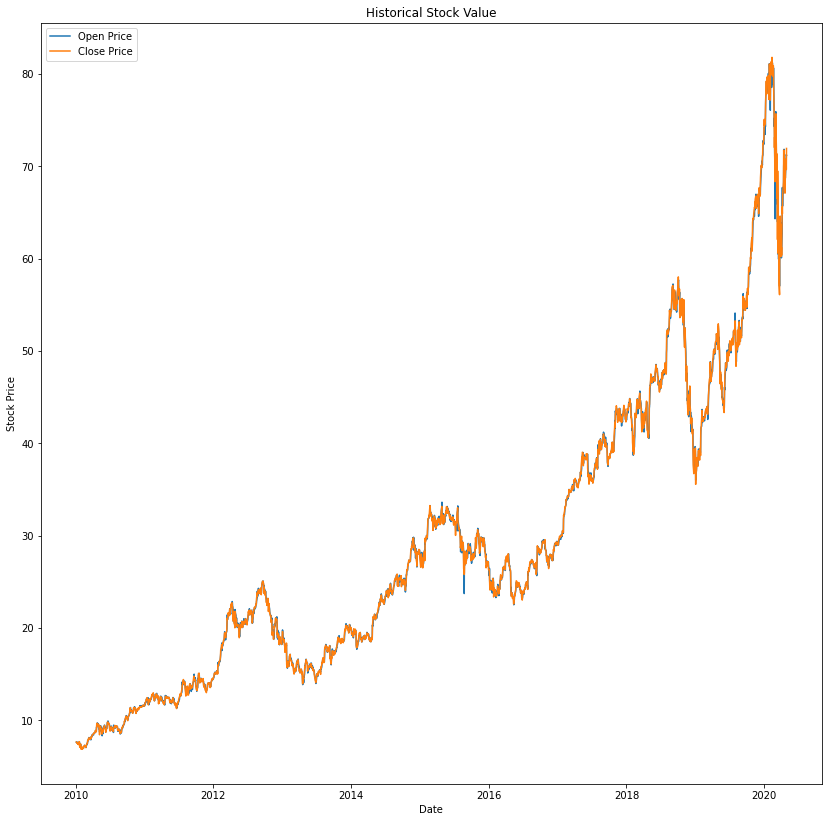

In [126]:
plt.figure(figsize=(14,14))
plt.plot(data['Open'], label='Open Price')
plt.plot(data['Close'], label='Close Price')
plt.title('Historical Stock Value')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [127]:
data['Date'] = data.index
filter_data = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
filter_data['Date'] = data['Date']
filter_data['Open'] = data['Open']
filter_data['High'] = data['High']
filter_data['Low'] = data['Low']
filter_data['Close'] = data['Close']

In [128]:
filter_data

,Date,Open,High,Low,Close
Date,,,,,
2010-01-04,2010-01-04,7.622500,7.660714,7.585000,7.643214
2010-01-05,2010-01-05,7.664286,7.699643,7.616071,7.656428
2010-01-06,2010-01-06,7.656428,7.686786,7.526786,7.534643
2010-01-07,2010-01-07,7.562500,7.571429,7.466072,7.520714
2010-01-08,2010-01-08,7.510714,7.571429,7.466429,7.570714
...,...,...,...,...,...
2020-04-23,2020-04-23,68.967499,70.437500,68.717499,68.757500
2020-04-24,2020-04-24,69.300003,70.752502,69.250000,70.742500
2020-04-27,2020-04-27,70.449997,71.135002,69.987503,70.792503


In [129]:
training_set = filter_data.iloc[:1700, 1:2].values
test_set = filter_data.iloc[1700:, 1:2].values
sc = MinMaxScaler(feature_range = (-1, 1))

In [130]:
#Training Data
training_set_scaled = sc.fit_transform(training_set)
X_train = []
y_train = []
for i in range(60, len(training_set)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [131]:
#Test Data
total_data =filter_data.iloc[:, 1:2]
inputs = total_data[len(total_data) - len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
    y_test.append(training_set_scaled[i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [132]:
#Defining the LSTM Recurrent Model
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

In [137]:
#Compiling and fitting the model
csv_logger = CSVLogger("model_history_log.csv")
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 10, batch_size = 32,callbacks=[csv_logger], validation_split=0.2 )

Epoch 1/10
41/41 [==============================] - 17s 172ms/step - loss: 0.0688 - val_loss: 0.0145
Epoch 2/10
41/41 [==============================] - 4s 101ms/step - loss: 0.0100 - val_loss: 0.0126
Epoch 3/10
41/41 [==============================] - 5s 113ms/step - loss: 0.0074 - val_loss: 0.0168
Epoch 4/10
41/41 [==============================] - 4s 105ms/step - loss: 0.0080 - val_loss: 0.0093
Epoch 5/10
41/41 [==============================] - 5s 110ms/step - loss: 0.0072 - val_loss: 0.0133
Epoch 6/10
41/41 [==============================] - 4s 104ms/step - loss: 0.0060 - val_loss: 0.0077
Epoch 7/10
41/41 [==============================] - 4s 103ms/step - loss: 0.0068 - val_loss: 0.0084
Epoch 8/10
41/41 [==============================] - 4s 97ms/step - loss: 0.0057 - val_loss: 0.0105
Epoch 9/10
41/41 [==============================] - 4s 102ms/step - loss: 0.0059 - val_loss: 0.0076
Epoch 10/10
41/41 [==============================] - 4s 96ms/step - loss: 0.0056 - val_loss: 0.0075


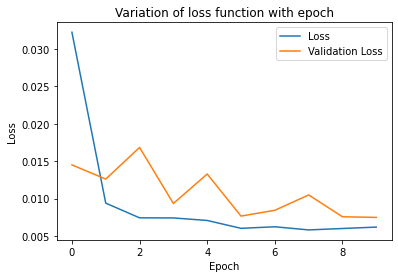

In [138]:
model_log_data = pd.read_csv("model_history_log.csv")
plt.plot(model_log_data["epoch"].values, model_log_data["loss"].values, label = "Loss")
plt.plot(model_log_data["epoch"].values, model_log_data["val_oss"].values, label = "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Variation of loss function with epoch')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [139]:
predicted_value = regressor.predict(X_test)
predicted_value = sc.inverse_transform(predicted_value)

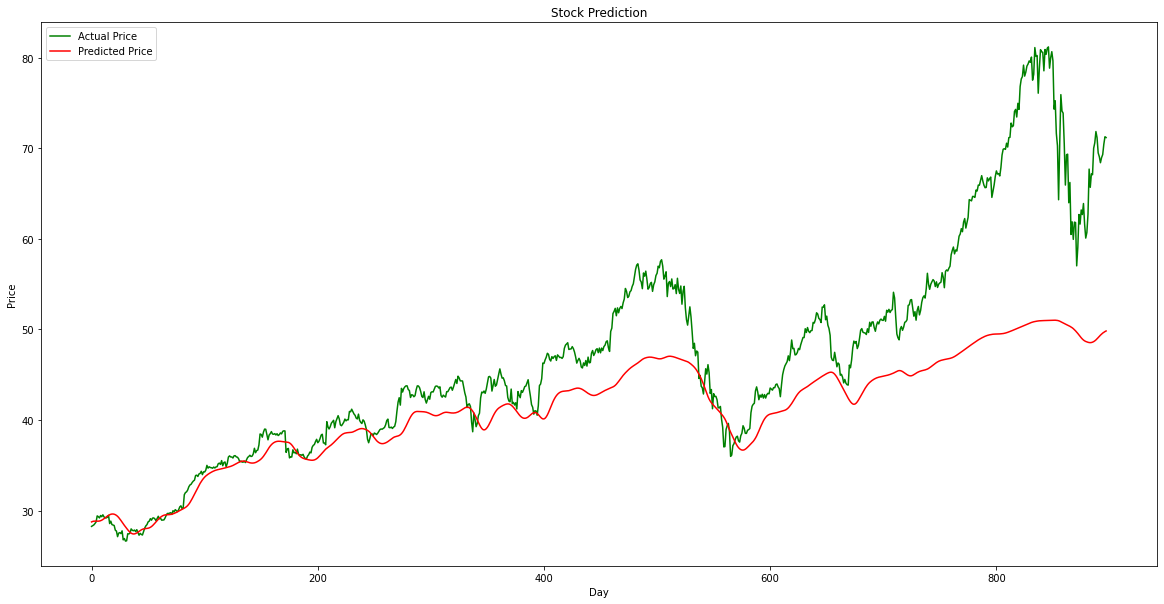

In [141]:
plt.figure(figsize=(20,10))
plt.plot(test_set, color = 'green', label = 'Actual Price')
plt.plot(predicted_value, color = 'red', label = 'Predicted Price')
plt.title('Stock Prediction')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()